In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import models
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
mnist_train = datasets.MNIST(root='./mnist/',train=True,transform=transform,download=True)
mnist_test = datasets.MNIST(root='./mnist/',train=False,transform=transform,download=True)

In [5]:
BATCH_SIZE = 256
train_iter = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

In [6]:
class ResnetBackBone(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_map = None

        self.backbone = models.resnet18(weights='DEFAULT')
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = nn.Linear(512, num_classes)

        self.backbone.layer4.register_forward_hook(self.getFeatureMap)

    def getFeatureMap(self, module, inputs, outputs):
        self.feature_map = outputs

    def forward(self, x):
        x = self.backbone(x)
        return x, self.feature_map

In [7]:
class TestModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, 1, 1),
        )
        self.gap = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.Linear(128, num_classes),
        )

    
    def forward(self, x):
        feature_map = self.conv(x)
        x = self.gap(feature_map)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, feature_map

In [8]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        model.eval()
        n_total,n_correct,f1 = 0,0,0
        for batch_in,batch_out in data_iter:
            x_trgt = batch_in.to(device)
            y_trgt = batch_out.to(device)
            model_pred, _ = model(x_trgt)
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += x_trgt.size(0)
            f1 += f1_score(y_trgt.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), average='macro')
        val_accr = (n_correct/n_total)
        f1 = f1/len(data_iter)
        model.train()
    return val_accr, f1

In [9]:
def madeCAM(feature_map, labels, weight):
    # B : label
    labels = labels.view(labels.size(0), -1)
    W = torch.stack([weight[:,labels[i]] for i in range(len(labels))]) # B C 1
    W = W.unsqueeze(dim=-1) # B C 1 1

    output = torch.mul(feature_map, W)
    output = torch.sum(output, dim=1)

    return output

In [10]:
def minMaxNormalize(inputs):
    # B H W
    _min, _ = torch.min(inputs, dim=1)
    _max, _ = torch.max(inputs, dim=1)

    _max = torch.unsqueeze(_max, dim=-1)
    _min = torch.unsqueeze(_min, dim=-1)

    numerator = torch.sub(inputs, _min)
    denominator = torch.sub(_max, _min)
    output = torch.div(numerator, denominator)

    return output

In [11]:
torch.autograd.set_detect_anomaly(True)
model = ResnetBackBone(10).to(device)
# optm_theta = optim.Adam(model.conv.parameters(),lr=1e-3)
theta_params = [param for name, param in model.backbone.named_parameters() if 'fc' not in name]
optm_theta = optim.SGD(theta_params,lr=1e-2)
# optm_w = optim.Adam(model.fc.parameters(), lr=1e-3)
optm_w = optim.SGD(model.backbone.fc.parameters(), lr=1e-2)
l_cam = nn.L1Loss()
l_ce = nn.CrossEntropyLoss()
model.train()
EPOCHS = 20
alpha = 0
for epoch in range(1, EPOCHS+1):
    loss_sum = 0
    L_cam_sum = 0
    L_ce_sum = 0
    for batch_in, batch_out in tqdm(train_iter):
        inputs = batch_in.to(device)
        labels = batch_out.to(device)
        y_pred, feature_map = model.forward(inputs)

        if epoch >= 10:
            alpha = 3
        
        # CAAM, CAM
        CAAM = torch.sum(feature_map, dim=1) # B H W
        # CAM = madeCAM(feature_map, labels, model.fc.weight.data.T) # B H W
        CAM = madeCAM(feature_map, labels, model.backbone.fc.weight.data.T) # B H W

        CAAM_normalize = minMaxNormalize(CAAM)
        CAM_noramlize = minMaxNormalize(CAM)
        
        L_cam_loss = l_cam(CAAM_normalize, CAM_noramlize) 
        L_ce_loss = l_ce(y_pred, labels)
        CAM_loss = alpha*L_cam_loss + L_ce_loss

        
        optm_theta.zero_grad()
        optm_w.zero_grad()
        CAM_loss.backward()
        optm_theta.step()
        optm_w.step()

        loss_sum += CAM_loss
        L_cam_sum += L_cam_loss
        L_ce_sum += L_ce_loss

    loss_avg = loss_sum/len(train_iter)
    cam_avg = L_cam_sum/len(train_iter)
    ce_avg = L_ce_sum/len(train_iter)

    if (epoch%2) == 0:
        train_accr, f1_train = func_eval(model,train_iter,device)
        test_accr, f1_test = func_eval(model,test_iter,device)
        print (f"epoch: {epoch} CAM_loss:{loss_avg:.3f}(L_cam: {cam_avg:.3f}, L_ce: {ce_avg:.3f}) train_accr: {train_accr:.3%} test_accr:{test_accr:.3%}, train_f1: {f1_train:.3f} test_f1: {f1_test:.3f}")
print ("Done")        

100%|██████████| 235/235 [00:29<00:00,  7.86it/s]


epoch: 2 CAM_loss:0.045(L_cam: 0.219, L_ce: 0.045) train_accr: 99.265% test_accr:98.860%, train_f1: 0.993 test_f1: 0.987


100%|██████████| 235/235 [00:29<00:00,  7.84it/s]


epoch: 4 CAM_loss:0.021(L_cam: 0.195, L_ce: 0.021) train_accr: 99.643% test_accr:99.030%, train_f1: 0.996 test_f1: 0.990


100%|██████████| 235/235 [00:29<00:00,  7.84it/s]


epoch: 6 CAM_loss:0.013(L_cam: 0.184, L_ce: 0.013) train_accr: 99.853% test_accr:99.220%, train_f1: 0.999 test_f1: 0.992


100%|██████████| 235/235 [00:29<00:00,  7.88it/s]


epoch: 8 CAM_loss:0.008(L_cam: 0.179, L_ce: 0.008) train_accr: 99.935% test_accr:99.240%, train_f1: 0.999 test_f1: 0.991


100%|██████████| 235/235 [00:29<00:00,  7.95it/s]


epoch: 10 CAM_loss:0.107(L_cam: 0.033, L_ce: 0.010) train_accr: 99.837% test_accr:99.220%, train_f1: 0.998 test_f1: 0.992


100%|██████████| 235/235 [00:30<00:00,  7.80it/s]


epoch: 12 CAM_loss:0.046(L_cam: 0.013, L_ce: 0.008) train_accr: 99.902% test_accr:99.300%, train_f1: 0.999 test_f1: 0.993


100%|██████████| 235/235 [00:29<00:00,  7.92it/s]


epoch: 14 CAM_loss:0.034(L_cam: 0.009, L_ce: 0.006) train_accr: 99.947% test_accr:99.300%, train_f1: 0.999 test_f1: 0.993


100%|██████████| 235/235 [00:30<00:00,  7.82it/s]


epoch: 16 CAM_loss:0.029(L_cam: 0.008, L_ce: 0.005) train_accr: 99.958% test_accr:99.330%, train_f1: 1.000 test_f1: 0.993


100%|██████████| 235/235 [00:29<00:00,  7.88it/s]


epoch: 18 CAM_loss:0.024(L_cam: 0.007, L_ce: 0.004) train_accr: 99.977% test_accr:99.330%, train_f1: 1.000 test_f1: 0.993


100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


epoch: 20 CAM_loss:0.021(L_cam: 0.006, L_ce: 0.004) train_accr: 99.980% test_accr:99.360%, train_f1: 1.000 test_f1: 0.994
Done


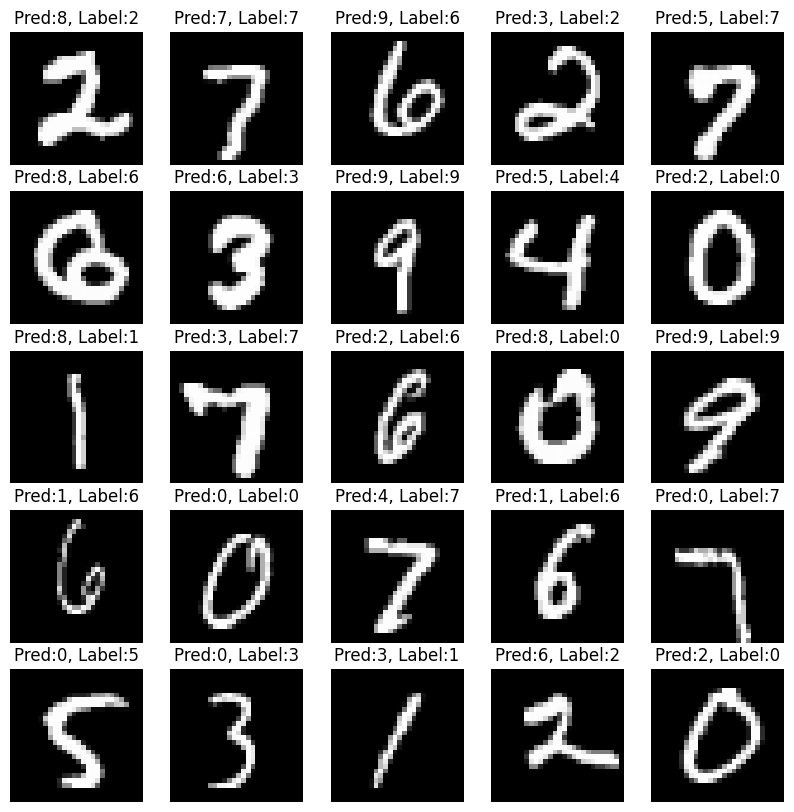

Done


In [34]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
test_x.unsqueeze_(dim=1)
with torch.no_grad():
    y_pred, _ = model(test_x.type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")